In [35]:
import sys
import os
import os.path
import fnmatch
from lxml import etree
from lxml.etree import tostring
import re
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pylab import plot
import pickle
import re
import matplotlib.patches as mpatches
from nltk.tokenize import word_tokenize

In [36]:
def process_files(list_of_files, path_in):
    
    words_dict=defaultdict(list)
    length_dict=defaultdict(list)
    chaps_dict=defaultdict(list)
    divs_dict=defaultdict(list)
    first_dict=defaultdict(list)
    last_dict=defaultdict(list)
    first_ent_dict=defaultdict(list)
    last_ent_dict=defaultdict(list)
    plot_words=OrderedDict()
    plot_chaps=OrderedDict()
    plot_div1=OrderedDict()
    plot_div2=OrderedDict()
    plot_div3=OrderedDict()
    plot_length=OrderedDict()
    plot_first=OrderedDict()
    plot_last=OrderedDict()
    plot_ent_first=OrderedDict()
    plot_ent_last=OrderedDict()
    filtered=list()
    bugs=list()
    stats=defaultdict(list)
    
    print("Processing "+str(len(list_of_files))+" files. Please wait, this might take some time.")

    for tmpFile in list_of_files:

        tmpFile=tmpFile.replace("/",":")
        fullPath=path_in+tmpFile

        print("\nProcessing file "+tmpFile)

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)

        #yearKey=int(tmpFile[:3]+"0")
            yearKey=int(tmpFile[:4])

            words_dict=num_words(words_dict,tree, yearKey, bugs, tmpFile)
            #print(words_dict.keys())
            chaps_dict=num_chapters(chaps_dict,tree,yearKey, bugs,tmpFile)
            
            divs_dict=num_divs(divs_dict, tree, yearKey, bugs, tmpFile)
            
            length_dict=length(length_dict, tree.getroot(), yearKey)
            
            first_dict=num_first(first_dict, tree, yearKey, tmpFile)
            
            last_dict=num_last(last_dict, tree, yearKey, tmpFile)
            
            first_ent_dict=num_ent_first(first_ent_dict, tree, yearKey, tmpFile)
            
            last_ent_dict=num_ent_last(last_ent_dict, tree, yearKey, tmpFile)
            

    plot_words=words_for_plot(words_dict, plot_words)
    plot_chaps=words_for_plot(chaps_dict, plot_chaps)
    plot_length=words_for_plot(length_dict, plot_length)
    plot_div1=divs_for_plot(divs_dict, plot_div1,1)
    plot_div2=divs_for_plot(divs_dict, plot_div2,2)
    plot_div3=divs_for_plot(divs_dict, plot_div3,3)
    plot_first=words_for_plot(first_dict, plot_first)
    plot_last=words_for_plot(last_dict, plot_last)
    plot_ent_first=words_for_plot(first_ent_dict, plot_ent_first)
    plot_ent_last=words_for_plot(last_ent_dict, plot_ent_last)
    #print(bugs)
    fit_words = lin_reg(plot_words)
    fit_chaps = lin_reg(plot_chaps)
    
    print(first_dict)
    print(last_dict)
    
    stats["chapter"].append(fit_chaps)
    stats["chapter"].append(plot_chaps)
    stats["word"].append(fit_words)
    stats["word"].append(plot_words)
    stats["divs"].append(plot_div1)
    stats["divs"].append(plot_div2)
    stats["divs"].append(plot_div3)
    stats["length"].append(plot_length)
    stats["exts"].append(plot_first)
    stats["exts"].append(plot_last)
    stats["ents"].append(plot_ent_first)
    stats["ents"].append(plot_ent_last)
    
    return stats

    #del filtered
    del words_dict
    del chaps_dict
    del plot_words
    del plot_chaps

In [37]:
def lin_reg(series):

    x = np.array(list(series.keys()))
    y = np.array(list(series.values()))

    x = sm.add_constant(x)

    return sm.OLS(y, x).fit()

In [38]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [39]:
def plot_stats (fit, plot,limitsX,limitsY, sliding, mycolor, title):
    x1 = list(plot.keys())[0]
    x2 = list(plot.keys())[-1]
    y1 = fit.predict()[0]
    y2 = fit.predict()[-1]
    x = np.array(list(plot.keys()))
    y = np.array(list(plot.values()))
    #print(len(plot.values()))
    yMA = movingaverage(y,sliding)
    plt.figure(figsize=(10, 6))
    plt.plot(list(plot.keys()), list(plot.values()))
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=5,color=mycolor)
    plt.title(title)
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    #plt.xlim(min(plot.keys()),max(plot.keys()))
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    #print(plot.keys())
    plt.show()

In [40]:
def simple_plot (plot, limitsX, limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot.keys()))
    y = np.array(list(plot.values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=5,color=mycolor)
    plt.plot(x,y)
    plt.title(title)
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.show()

In [41]:
def multiple_plots (stats):
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['word'][1].keys()))
        y=np.array(list(stats[name]['word'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(min(stats[name]['word'][1].keys()),30000)
        plt.xlim(1800,1910)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de mots par chapitre")
    plt.show()
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['chapter'][1].keys()))
        y=np.array(list(stats[name]['chapter'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(0,80)
        plt.xlim(1800,1910)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de chapitres")
    plt.show()

In [42]:
def hierarchy_plots (plot,limitsX,limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot[0].keys()))
    y = np.array(list(plot[0].values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=2,color=mycolor[0])
    x1 = np.array(list(plot[1].keys()))
    y1 = np.array(list(plot[1].values()))
    yMA1 = movingaverage(y1,sliding)
    plt.plot(x1[len(x1)-len(yMA1):],yMA1,linewidth=2,color=mycolor[1])
    x2 = np.array(list(plot[2].keys()))
    y2 = np.array(list(plot[2].values()))
    yMA2 = movingaverage(y2,sliding)
    plt.plot(x2[len(x2)-len(yMA2):],yMA2,linewidth=2,color=mycolor[2])
    plt.legend(loc='upper left')
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.title(title)
    patch1 = mpatches.Patch(color=color[0], label='niveau 1')
    patch2 = mpatches.Patch(color=color[1], label='niveau 2')
    patch3 = mpatches.Patch(color=color[2], label='niveau 3')
    plt.legend(handles=[patch1, patch2, patch3])
    plt.show()

In [43]:
def first_n_last_plots (plot,limitsX,limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot[0].keys()))
    y = np.array(list(plot[0].values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=2,color=mycolor[0])
    x1 = np.array(list(plot[1].keys()))
    y1 = np.array(list(plot[1].values()))
    yMA1 = movingaverage(y1,sliding)
    plt.plot(x1[len(x1)-len(yMA1):],yMA1,linewidth=2,color=mycolor[1])
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.legend(loc='upper left')
    plt.title(title)
    patch1 = mpatches.Patch(color=color[0], label='first')
    patch2 = mpatches.Patch(color=color[1], label='last')
    
    plt.legend(handles=[patch1, patch2])
    plt.show()

In [44]:
def num_words (words_dict,tree,yearKey,bugs,tmpFile):
    execute=False
    words=list()
    if tree.findall(".//div[@type='chapter']"):
        for chapter in tree.findall(".//div[@type='chapter']"):
            numWords=len(chapter.findall(".//word"))
            words.append(numWords)
            execute=True
    elif tree.findall(".//div[@type='part']"):
        for chapter in tree.findall(".//div[@type='part']"):
            numWords=len(chapter.findall(".//word"))
            words.append(numWords)
            execute=True
    
    else :
        for p in tree.findall(".//p"):
            numWords=len(p.findall(".//word"))
            words.append(numWords)
            execute=True
    
    if execute==True:
        average=sum(words)/len(words)
        words_dict[yearKey].append(average)
    return words_dict

In [45]:
def length (length_dict, node, yearKey):
    length_dict[yearKey].append(len(node.findall(".//word")))
    return length_dict

In [46]:
def num_chapters (chaps_dict,tree, yearKey,bugs,tmpFile):
    execute=False
    chapters=list()
    if tree.findall(".//div[@type='chapter']"):
        num_chaps=len(tree.findall(".//div[@type='chapter']"))
        execute=True
    elif tree.findall(".//div[@type='part']"):
        num_chaps=len(tree.findall(".//div[@type='part']"))
        execute=True
    
    else :
        bugs.append(tmpFile+" ; ")
        execute=False
    
    if execute==True:
        chaps_dict[yearKey].append(num_chaps)
        
    else :
        chaps_dict[yearKey].append(0)
    return chaps_dict

In [83]:
def num_divs (divs_dict,tree, yearKey,bugs,tmpFile):
    execute=False
    chapters=list()
    if tree.findall(".//div[@type='chapter']") and tree.findall(".//div[@type='part']") and tree.findall(".//div[@type='book']"):
        num_divs=3
    elif tree.findall(".//div[@type='chapter']") and tree.findall(".//div[@type='part']"):
        num_divs=2
    elif tree.findall(".//div[@type='chapter']") or tree.findall(".//div[@type='part']" or tree.findall(".//div[@type='book']")):
        num_divs=1
    else :
        num_divs=0
    
    divs_dict[yearKey].append(num_divs)
    
    return divs_dict

In [48]:
def num_first (ext_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext1=len(chaps[0].findall(".//word"))
        ext_dict[yearKey].append(ext1)
        if ext1==0:
            print ("Problem (first chap) with file : "+file)
    return ext_dict

In [49]:
def num_ent_first (ext_ent_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext1=len(chaps[0].xpath(".//word[starts-with(@postag, 'NAME')]"))
        if (ext1>1000):
            if 'title' in chaps[0].attrib:
                print(chaps[0].attrib['title'])
            print(ext1)
        ext_ent_dict[yearKey].append(ext1)
    return ext_ent_dict

In [50]:
def num_last (ext_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext2=len(chaps[len(chaps)-1].findall(".//word"))
        ext_dict[yearKey].append(ext2)
        if ext2==0:
            print ("Problem (last chap) with file : "+file)
    return ext_dict

In [51]:
def num_ent_last (ext_ent_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext1=len(chaps[len(chaps)-1].xpath(".//word[starts-with(@postag, 'NAME')]"))
        ext_ent_dict[yearKey].append(ext1)
    return ext_ent_dict

In [52]:
def words_for_plot (words_dict, plot_words):
    for year in sorted(words_dict.keys()):
        if len(words_dict[year])>0:
        #moyenne nombre de mots par année
            plot_words[year]=sum(words_dict[year])/len(words_dict[year])
    return plot_words

In [53]:
def divs_for_plot (divs_dict, plot_divs, hierarchy):
    for year in sorted(divs_dict.keys()):
        plot_divs[year]=divs_dict[year].count(hierarchy)
    return plot_divs

In [54]:
def by_attribute (list_of_files, path_in, lxml_string):
    filtered=list()
    for tmpFile in list_of_files:

        fullPath=path_in+tmpFile.replace("/",":")

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)
        
            if tree.findall(lxml_string):
                filtered.append(tmpFile)
    return filtered

In [55]:
def by_element_value (list_of_files, path_in, lxml_string, value_to_check):
    filtered=list()
    for tmpFile in list_of_files:

        fullPath=path_in+tmpFile.replace("/",":")

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)
        
            if tree.findall(lxml_string):
                for elem in tree.findall(lxml_string):
                    if elem.text and value_to_check in elem.text:
                        filtered.append(tmpFile)
    return filtered

In [56]:
def by_name (list_of_files, path_in, author):
    files_by_author=list()
    for tmpFile in list_of_files:
        fullPath=path_in+tmpFile.replace("/",":")
        if os.path.isfile(fullPath):
            result = re.search('[0-9]{4}(.*)_', tmpFile)
            name= result.group(1)
            if author in name:
                files_by_author.append(tmpFile)
    return files_by_author

In [84]:
%matplotlib inline
path_to_folder='/home/odysseus/Bureau/ANR/corpus/tagged_rest/'
#path_to_folder='/home/odysseus/Bureau/ANR/romans/'
authors=['_Dumas','_Zola','_Maupassant','_Sand-G',"_Ponson","_Flaubert"]

print("Statistiques globales : ")
files_list=fnmatch.filter(os.listdir(path_to_folder), '*.xml')

#stats_authors=OrderedDict()
#for author in authors:
    #names=by_name(files_list, path_to_folder,author)
    #stats_authors[author]=process_files(names, path_to_folder)
#pickle.dump(stats_authors, open("stats_authors","wb"))
    
stats_global=process_files(files_list, path_to_folder)

#canon_list=by_attribute(files_list, path_to_folder,".//profileDesc[@tag='canon']")
#stats_canon=process_files(canon_list, path_to_folder)

#genre_list=by_element_value(files_list, path_to_folder,".//term","populaire")
#stats_genre=process_files(genre_list, path_to_folder)

pickle.dump(stats_global, open("stats_rest","wb"))
#pickle.dump(stats_canon, open("stats_rest_canon","wb"))
#pickle.dump(stats_genre, open("stats_rest_populaire","wb"))

Statistiques globales : 
Processing 822 files. Please wait, this might take some time.

Processing file 1858_Segur-comtesse-de_Les-Malheurs-de-Sophie.xml

Processing file 1850_Dumas-Alexandre_Le-Vicomte-de-Bragelonne.xml

Processing file 2014_Volodine-Antoine_Terminus-radieux.xml

Processing file 1909_Boylesve-Rene_La-jeune-fille-bien-elevee.xml

Processing file 1872_Zola-Emile_La-curee.xml

Processing file 1861_Erckmann-Chatrian_Confidences-d-un-joueur-de-clarinette.xml

Processing file 1920_Toulet-Paul-Jean_La-jeune-fille-verte-roman.xml

Processing file 1961_Troyat-Henri_La-gloire-des-vaincus.xml

Processing file 1888_Malot-Hector_Conscience.xml

Processing file 1944_Aragon-Louis_Aurelien.xml

Processing file 1951_Rebatet-Lucien_Les-Deux-Etendards.xml

Processing file 1991_Bauchau-Henry_Diotime-et-les-lions.xml

Processing file 1847_Collin-de-Plancy-Jacques-Albin-Simon-(1794-1881)_Legende-du-Juif-Errant.xml

Processing file 1861_Rocca-Maria-della-(nee-Embden-Heine-pseud-Camille-Henr


Processing file 2008_Riboulet-Mathieu_L-Amant-Des-Morts.xml

Processing file 1908_Leroux-Gaston_Le-mystere-de-la-chambre-jaune.xml

Processing file 1885_Zola-Emile_Germinal.xml

Processing file 1978_Perec-Georges_La-Vie-mode-d-emploi.xml

Processing file 1894_Rachilde_Le-Demon-de-l-Absurde.xml

Processing file 1866_Feval-Paul-(pere)_L-avaleur-de-sabres-Les-Habits-Noirs-Tome-VI.xml

Processing file 1857_Feval-Paul-(pere)_Les-Errants-de-la-nuit.xml

Processing file 1907_Apollinaire-Guillaume_Les-Onze-mille-verges-ou-les-Amours-d-un-hospodar.xml

Processing file 2006_Quignard-Pascal_Villa-Amalia.xml

Processing file 1877_Zola-Emile_L-assomoir.xml

Processing file 1876_Malot-Hector_L-Auberge-du-monde-Tome-1.xml

Processing file 1952_Calet-Henri_Un-Grand-Voyage.xml

Processing file 2014_Rouaud-Jean_Un-peu-la-guerre.xml

Processing file 1908_Dhanys-Marcel_Marcel-Dhanys-Le-Roman-du-grand-Conde-Edition-3-(1908).xml

Processing file 1858_Segur-comtesse-de_Les-Petites-Filles-Modeles.xml

Proces


Processing file 1910_Audoux-Marguerite_Marie-Claire.xml

Processing file 1890_Ohnet-Georges_L-Ame-de-Pierre.xml

Processing file 1845_Walsh-Joseph-Alexis_Les-Veillees-de-voyage.xml

Processing file 1921_Bourget-Paul_L-Ecuyere.xml

Processing file 1968_Simonin-Albert_Le-Hotu.xml

Processing file 1984_Daeninckx-Didier_Le-der-des-ders.xml

Processing file 1853_Chavannes-de-La-Giraudiere-Hippolyte-de_Les-Petits-voyageurs-en-Californie.xml

Processing file 2013_Thiery-Danielle_La-petite-fille-de-Marie-Gare.xml

Processing file 1970_Simenon-Georges_La-folle-de-Maigret.xml

Processing file 1932_Lallier-Joseph_Le-spectre-menaçant.xml

Processing file 2015_Despentes-Virginie_Vernon-Subutex-T1.xml

Processing file 1870_Daudet-Alphonse_Le-Nabab.xml

Processing file 1865_Goncourt-Edmond-et-Jules-de_Germinie-Lacerteux.xml

Processing file 1936_Bernanos-Georges_Le-Journal-d-un-cure-de-campagne.xml

Processing file 1998_Daeninckx-Didier_Cannibale.xml

Processing file 1930_Giono-Jean_Regain.xml

Proc


Processing file 1916_Hemon-Louis_Maria-Chapdelaine.xml

Processing file 1982_Chessex-Jacques_Judas-le-transparent.xml

Processing file 1888_Coppee-François_Henriette.xml

Processing file 1876_Montepin-Xavier-de_Le-Ventriloque-L-assassin-de-Mariette.xml

Processing file 1876_Sarcey-Francisque_Etienne-Moret.xml

Processing file 1850_Lamartine-Alphonse-de_Genevieve--histoire-d-une-servante.xml

Processing file 1919_Bourget-Paul_Laurence-Albani.xml

Processing file 1957_Blanchot-Maurice_Le-Dernier-Homme.xml

Processing file 1861_Gondrecourt-Aristide-de_Le-Pays-de-la-peur-(tome-3).xml

Processing file 1929_Saint-Exupery-Antoine-de_Courrier-Sud.xml

Processing file 1927_Gide-Andre_Les-Faux-monnayeurs.xml

Processing file 1848_Dumas-Alexandre_La-dame-aux-camelias.xml

Processing file 1904_Le-Rouge-Gustave_L-Esclave-amoureuse.xml

Processing file 1859_Strub-Florence_L-Ermite-de-Vallombreuse-suivi-de-Madeleine.xml

Processing file 1997_Vargas-Fred_Sans-feu-ni-lieu.xml

Processing file 1878_Zol


Processing file 1936_Montherlant-Henry-de_Les-jeunes-filles.xml

Processing file 1890_Hameau-Louise_Mademoiselle-Pourquoi.xml

Processing file 1865_ Verne-Jules_Les-Forceurs-de-blocus.xml

Processing file 1942_Aragon-Louis_Les-Voyageurs-de-l-Imperiale.xml

Processing file 1924_Descaves-Lucien_L-Hirondelle-sous-le-toit.xml

Processing file 2011_Lemaitre-Pierre_Alex.xml

Processing file 1978_Modiano-Patrick_Rue-des-boutiques-obscures.xml

Processing file 1858_Gouraud-Julie_Les-Vacances-d-Yvonne.xml

Processing file 2002_Chandernagor-Françoise_La-Chambre.xml

Processing file 1864_Ulbach-Louis_Memoires-d-un-inconnu.xml

Processing file 2011_Darrieussecq-Marie_Cleves.xml

Processing file 1886_Mirbeau-Octave_Le-Calvaire.xml

Processing file 1964_Duras-Marguerite_Le-Ravissement-de-Lol-V-Stein.xml

Processing file 2008_Quignard-Pascal_Boutes.xml

Processing file 2007_Jouet-Jacques_Une-mauvaise-maire.xml

Processing file 1870_Zola-Emile_La-fortune-des-Rougon.xml

Processing file 1988_Djian-Phi


Processing file 2011_Beigbeder-Frederic_99-Francs.xml

Processing file 1960_Troyat-Henri_La-Barynia.xml

Processing file 1880_Ulbach-Louis_Le-Chateau-des-Epines-par-Louis-Ulbach-(1880).xml

Processing file 1881_Lermina-Jules_La-haute-canaille-(1881).xml

Processing file 1892_Mendes-Catulle_Luscignole.xml

Processing file 1879_Bouvier-Alexis_La-Belle-Grelee.xml

Processing file 1887_Soboleska-Mme-(pseud-Jacques-Lermont)_Les-Jeunes-filles-de-Quinnebasset.xml

Processing file 1885_Guy-de-Maupassant_Bel-ami.xml

Processing file 1904_Rolland-Romain_Jean-Christophe-Tome-I-L-aube.xml

Processing file 1978_Robbe-Grillet-Alain_Souvenirs-du-triangle-d-or.xml

Processing file 1960_Bealu-Marcel_Contes-du-demi-sommeil.xml

Processing file 1987_Bergounioux-Pierre_La-maison-rose.xml

Processing file 1994_Jonquet-Thierry_La-vie-de-ma-mere.xml

Processing file 1949_Simenon-Georges_Maigret-et-la-vieille-dame.xml

Processing file 2011_Sollers-Philippe_Tresor-d-amour.xml

Processing file 1883_Guy-de-Maup


Processing file 1876_Huysmans-Joris-Karl_Marthe-histoire-d-une-fille.xml

Processing file 1862_Verne-Jules_Cinq-Semaines-en-ballon.xml

Processing file 1973_Deon-Michel_Un-Taxi-mauve.xml

Processing file 1874_Fleuriot-Zenaide_En-conge.xml

Processing file 2011_Reinhardt-Eric_Le-systeme-Victoria.xml

Processing file 2002_Gaude-Laurent_La-Mort-du-roi-Tsongor.xml

Processing file 1911_Rosny-aine-J-H_La-guerre-du-feu.xml

Processing file 1926_Ramuz-Charles-Ferdinand_La-grande-peur-dans-la-montagne.xml

Processing file 1934_Leblanc-Maurice_Le-chapelet-rouge.xml

Processing file 1867_Houssaye-Arsene_La-Pantoufle-de-Cendrillon-ou-Suzanne-aux-coquelicots.xml

Processing file 1946_Bealu-Marcel_Journal-d-un-mort.xml

Processing file 2008_Musso-Guillaume_Je-reviens-te-chercher.xml

Processing file 1876_Sand-George_Contes-d-une-grand-mere.xml

Processing file 2008_Echenoz-Jean_Courir.xml

Processing file 1963_Pagnol-Marcel_Manon-des-sources.xml

Processing file 1985_Barjavel-Rene_La-peau-de-Cesar

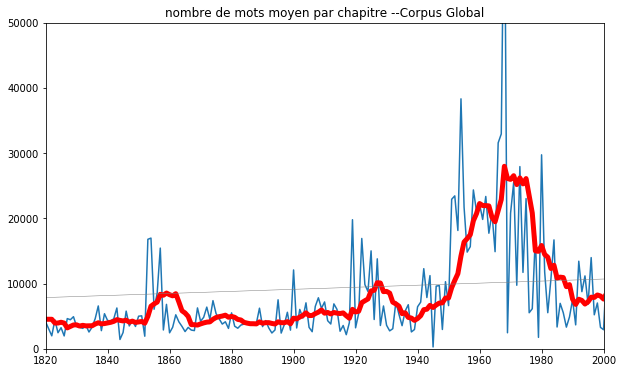

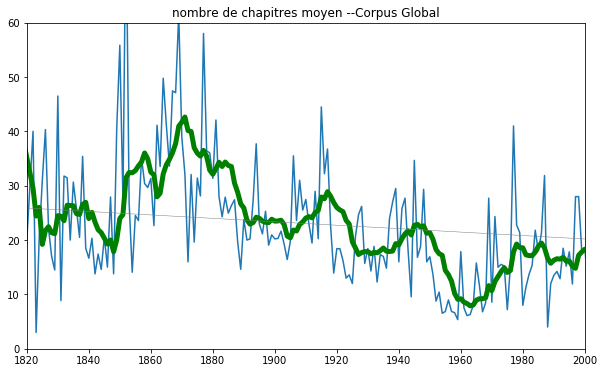

In [28]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1820,2016]
limitsWord=[0,50000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_global["word"][0],stats_global["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre --Corpus Global")
plot_stats(stats_global["chapter"][0],stats_global["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen --Corpus Global")

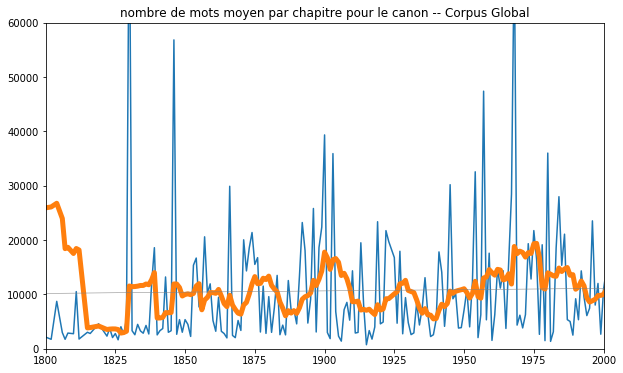

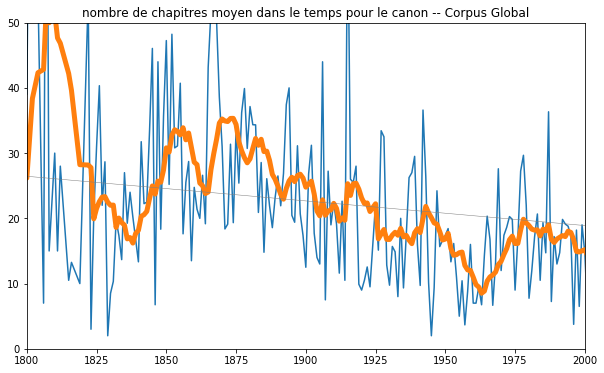

In [54]:
stats_canon=pickle.load(open( "stats_global_canon", "rb"))
limitsX=[1800,2000]
limitsWord=[0,60000]
limitsChap=[0,50]
sliding=10
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,"nombre de mots moyen par chapitre pour le canon -- Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX,limitsChap,sliding,"nombre de chapitres moyen dans le temps pour le canon -- Corpus Global")

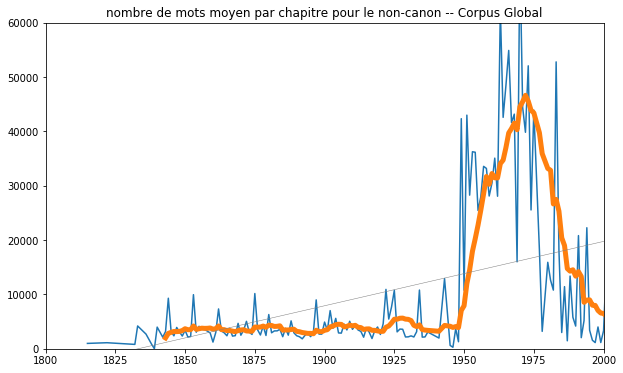

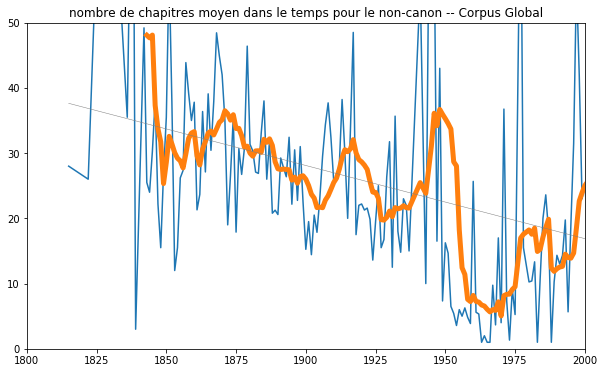

In [57]:
stats_canon=pickle.load(open( "stats_global_non-canon", "rb"))
limitsX=[1800,2000]
limitsWord=[0,60000]
limitsChap=[0,50]
sliding=10
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,"nombre de mots moyen par chapitre pour le non-canon -- Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX,limitsChap,sliding,"nombre de chapitres moyen dans le temps pour le non-canon -- Corpus Global")

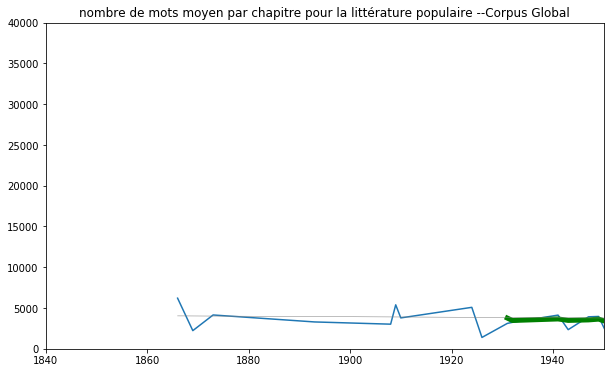

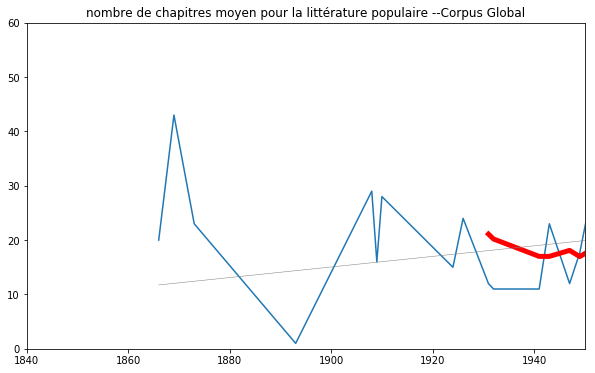

In [19]:
stats_canon=pickle.load(open( "stats_rest_policier", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour la littérature populaire --Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour la littérature populaire --Corpus Global")

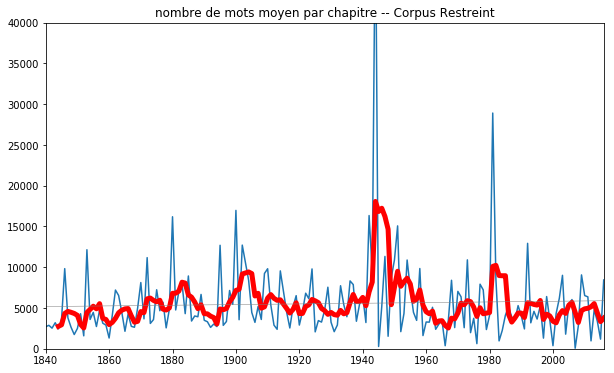

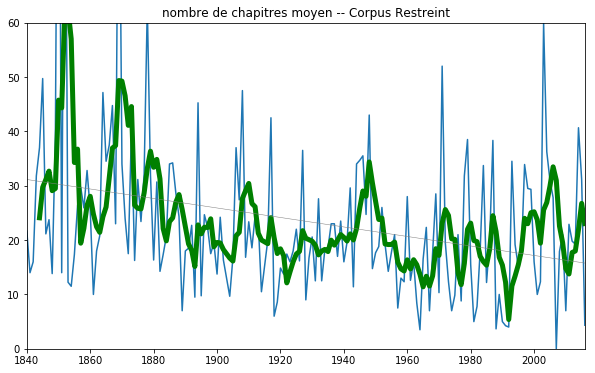

In [85]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=5
color=['r','g']
plot_stats(stats_global["word"][0],stats_global["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre -- Corpus Restreint")
plot_stats(stats_global["chapter"][0],stats_global["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen -- Corpus Restreint")

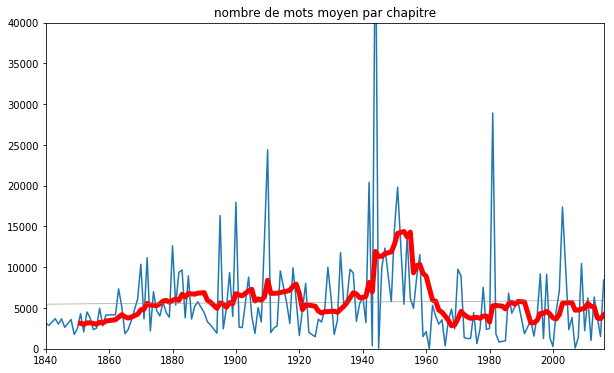

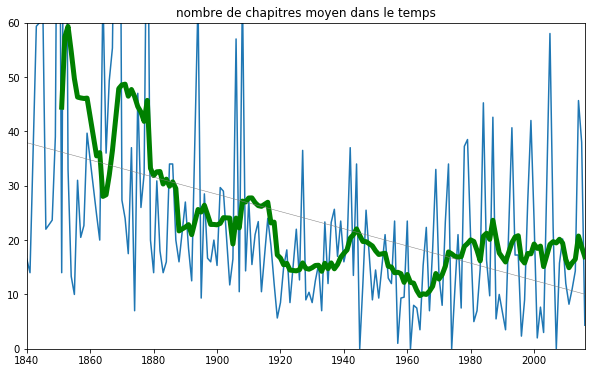

In [65]:
stats_canon=pickle.load(open( "stats_rest_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps")

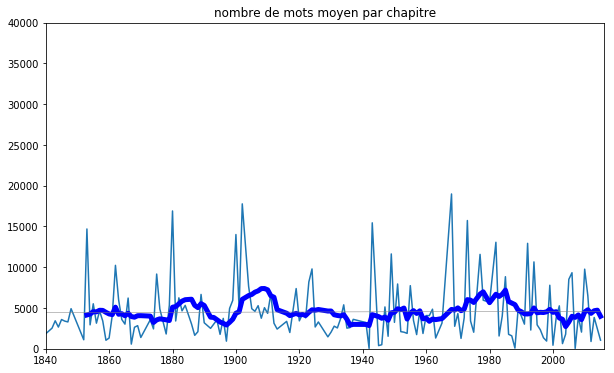

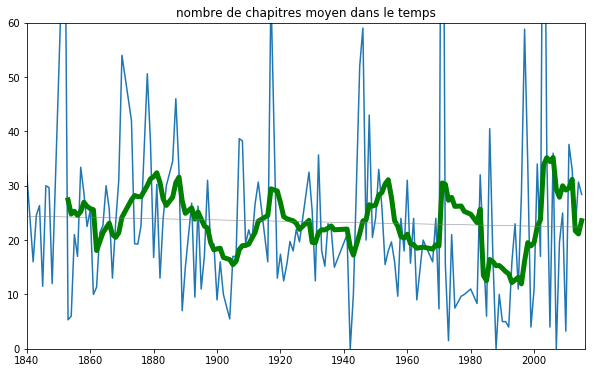

In [66]:
stats_canon=pickle.load(open( "stats_rest_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['b','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps")

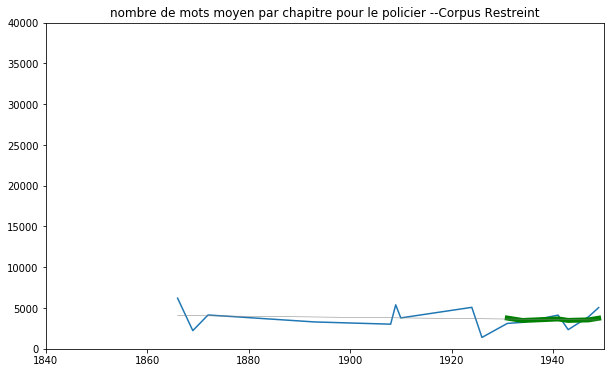

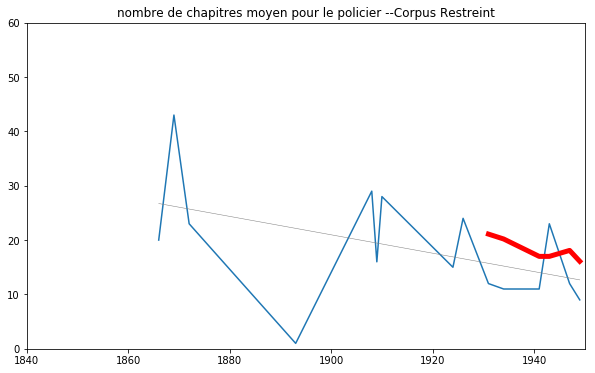

In [108]:
stats_canon=pickle.load(open( "stats_rest_policier", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour le policier --Corpus Restreint")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour le policier --Corpus Restreint")

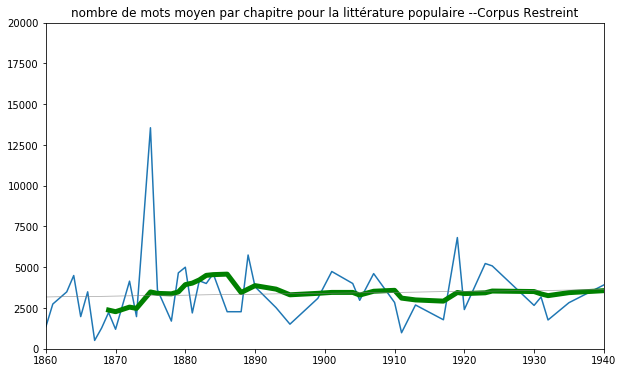

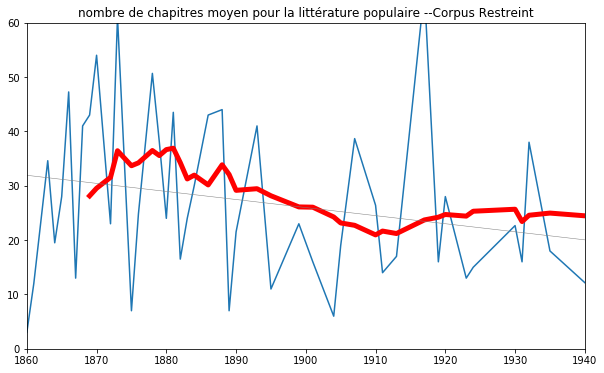

In [17]:
stats_canon=pickle.load(open( "stats_rest_populaire", "rb"))
limitsX=[1860,1940]
limitsWord=[0,20000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour la littérature populaire --Corpus Restreint")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour la littérature populaire --Corpus Restreint")

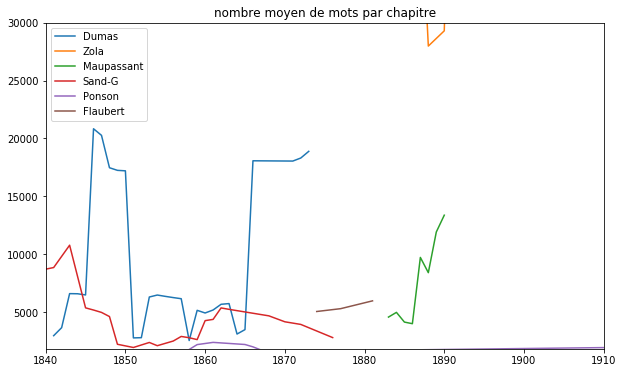

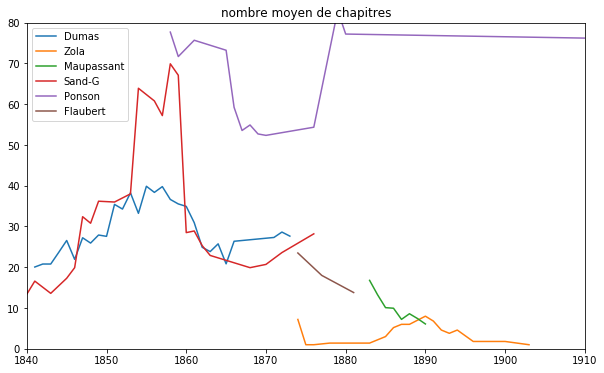

In [39]:
stats_authors=pickle.load(open("stats_authors","rb"))
multiple_plots(stats_authors)

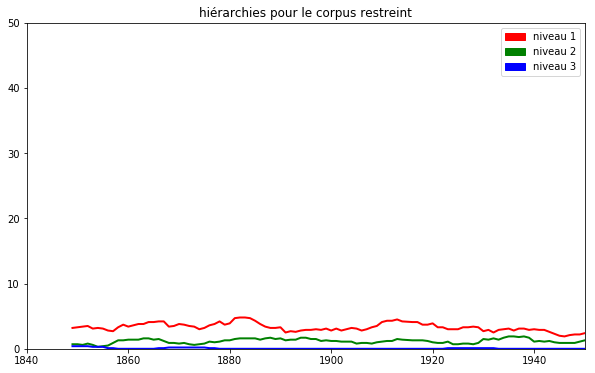

In [86]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,1950]
limitsWord=[0,50]
color=['r','g','b']
sliding=10
hierarchy_plots(stats_global["divs"],limitsX,limitsWord, sliding, color, "hiérarchies pour le corpus restreint")

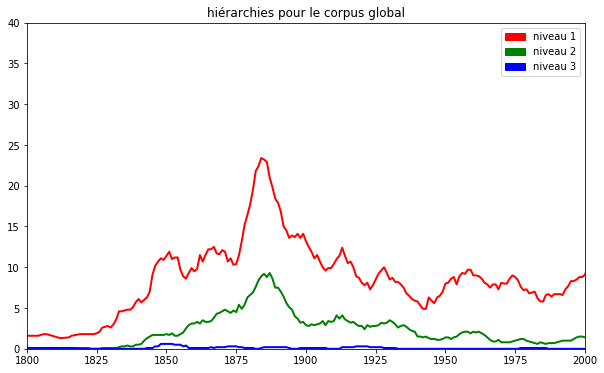

In [71]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1800,2000]
limitsWord=[0,40]
color=['r','g','b']
sliding=10
hierarchy_plots(stats_global["divs"],limitsX,limitsWord, sliding, color, "hiérarchies pour le corpus global")

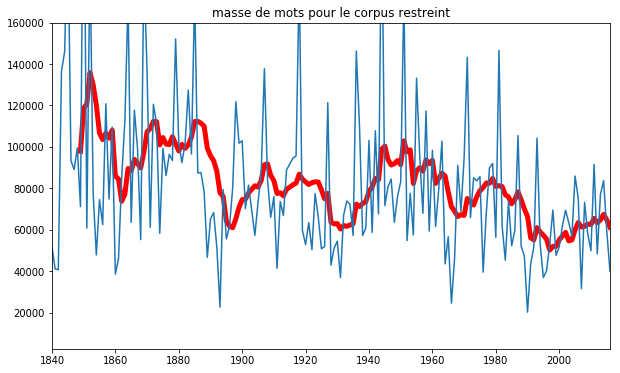

In [87]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,160000]
color='r'
sliding=10
simple_plot(stats_global["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint")

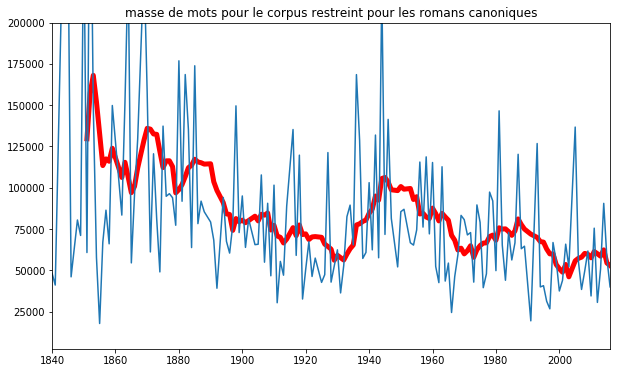

In [75]:
stats_canon=pickle.load(open("stats_rest_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint pour les romans canoniques")

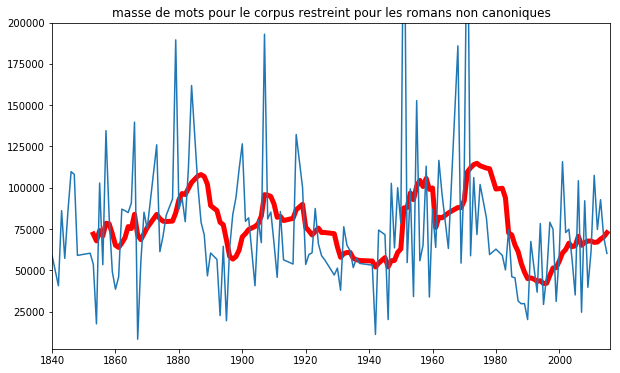

In [76]:
stats_non_canon=pickle.load(open("stats_rest_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_non_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint pour les romans non canoniques")

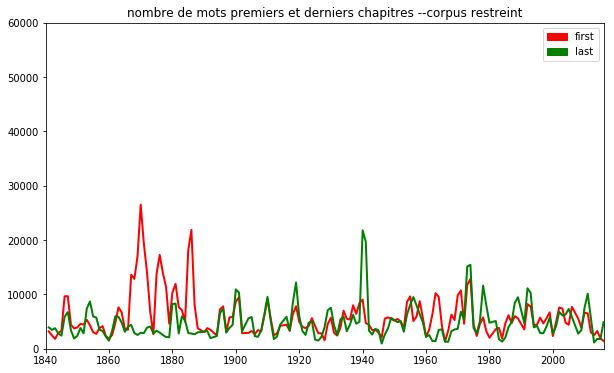

In [88]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus restreint")

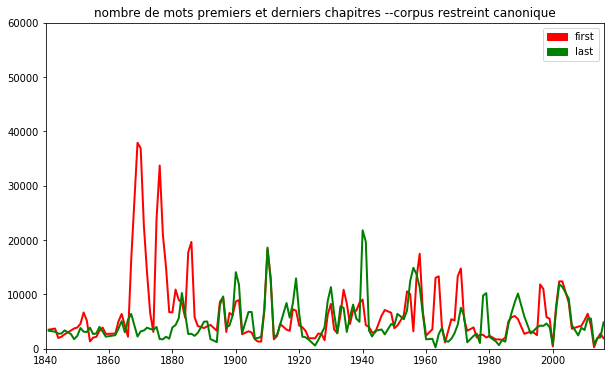

In [78]:
stats_global=pickle.load(open( "stats_rest_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus restreint canonique")

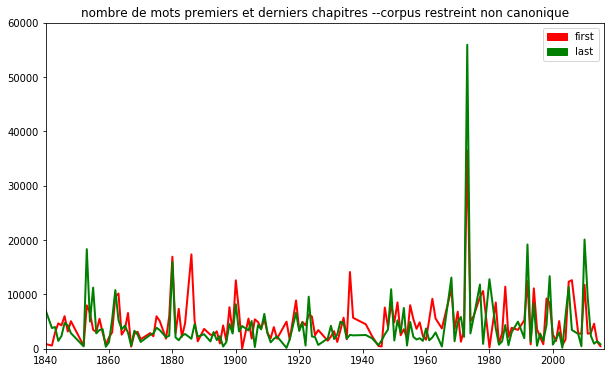

In [82]:
stats_global=pickle.load(open( "stats_rest_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=1
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus restreint non canonique")

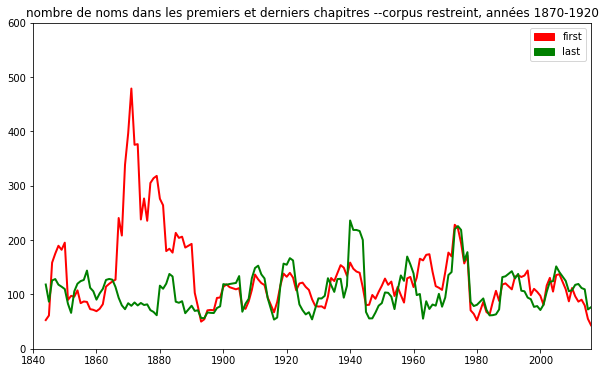

In [89]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[0,600]
color=['r','g']
sliding=5
first_n_last_plots(stats_global["ents"],limitsX,limitsWord, sliding, color, "nombre de noms dans les premiers et derniers chapitres --corpus restreint, années 1870-1920")